# JPX LightGBM Demo

## Read files 
* **stock_prices, options, financials, trades,   secondary_stock_price, stock_list**

Contest overview
* Japan Exchange Group (JPX) forecasts the rate of change in securities prices (closing prices) for 2000 securities
* The objective variable is the rate of change in the closing price from the next day to the day after next.
* The submitted data is not the value of the objective variable itself, but the order when the values ​​of the objective variable are arranged in descending order.
* If you want to know more about the contest, [Japanese ver] Easy to understand the competition will be very useful.

Notebook overview
* In this notebook, **[Data reading]-> [Data integration]-> [Feature quantity engineering]-> [Learning]-> [Inference / evaluation]-> [Submission]** is performed all at once.
* The model used is LightGBM.
* Generate three models and ensemble the results to create the final inference result.

The flow up to inference and evaluation is as follows --
The red background is a function used only for inference / evaluation estimation. The blue background is the function / data used at the time of submission -- 
By customizing the function on the blue background, accuracy verification can be performed with various features, and submit can be performed as it is.

* **Read files**
* stock_prices,options,financials,trades,secondary_stock_price,stock_list
* **collector**
* merge_data=> adjust price=> **base_df**
* **preprocessor**
* generate_features (add_columns_per_code=> add columns_per_day) => select_features => **feature_df**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# !unzip /content/drive/MyDrive/jpx-tokyo-stock-exchange-prediction.zip

In [2]:
import os
from pathlib import Path
from decimal import ROUND_HALF_UP, Decimal

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

* **stock_list.csv**
* **train_files （Date: 2017-01-04 ～ 2021-12-03）**
* **supplemental_files （Date: 2021-12-06 ～ 2022-02-28 __ 2022/04/05(current)）**

In [3]:
def read_files(dir_name: str = 'data'):
    base_path = Path(f'{dir_name}')
    prices = pd.read_csv(base_path / 'stock_prices.csv')
    options = pd.read_csv(base_path / 'options.csv')
    financials = pd.read_csv(base_path / 'financials.csv')
    trades = pd.read_csv(base_path / 'trades.csv')
    secondary_prices = pd.read_csv(base_path / 'secondary_stock_prices.csv')
    return prices, options, financials, trades, secondary_prices

In [4]:
stock_list = pd.read_csv('data/stock_list.csv')
train_files = read_files('data/train_files')
supplemental_files = read_files('data/supplemental_files')

* The merge_data function merges each file horizontally. At the moment, we only use stock_prices and stock_list.
* If you uncomment it, you can combine it with trades and financials,
Since the timing at which valid records are generated is not daily for these data, it is necessary to take measures such as "inheriting the values ​​of the most recently generated valid records" in order to make them meaningful as learning data. increase.
* Regarding options, if you look at the attached rule https://www.jpx.co.jp/derivatives/index.html) of OptionsCode, you can see the proper usage.

## Collector ( merge_data  =>  adjust price  =>  **base_df** )

In [5]:
def merge_data(prices, options, financials, trades, secondary_prices, stock_list):
    # Based on stock_prices
    base_df = prices.copy()
    
    
    # Combine with #stock_list
    _stock_list = stock_list.copy()
    _stock_list.rename(columns={'Close': 'Close_x'}, inplace=True)
    base_df = base_df.merge(_stock_list, on='SecuritiesCode', how="left")

    # Combine with trades
    # Edit the Section item of trades so that it is linked to the New Market Segment of stock_list.
    # _trades = trades.copy()
    # _trades['NewMarketSegment'] = _trades['Section'].str.split(' \(', expand=True)[0]
    # base_df = base_df.merge(_trades, on=['Date', 'NewMarketSegment'], how="left")

    # Combine with financials
    # _financials = financials.copy()
    # _financials.rename(columns={'Date': 'Date_x', 'SecuritiesCode': 'SecuritiesCode_x'}, inplace=True)
    # base_df = base_df.merge(_financials, left_on='RowId', right_on='DateCode', how="left")
    
    return base_df

* The adjust_price function uses the function introduced in Train Demo almost as it is.(Only the indexing of Date is commented out)
* It is beyond the scope of integration due to the addition of items, but it is being executed at this stage because operations such as sorting and index generation are performed within the function.
* The function will generate an item called AdjustedClose.
* Stock prices can fluctuate significantly due to splits and mergers, but by using Adjusted Close instead of Close, this effect can be reduced.

In [6]:
def adjust_price(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)

    # price.set_index("Date", inplace=True)
    return price

In [7]:
def collector(prices, options, financials, trades, secondary_prices, stock_list):
    # Consolidate the read data into one file
    base_df = merge_data(prices, options, financials, trades, secondary_prices, stock_list)
    # Generate AdjustedClose item
    base_df = adjust_price(base_df)
    
    return base_df

In [8]:
%%time
base_df = collector(*train_files, stock_list)
supplemental_df = collector(*supplemental_files, stock_list)
base_df = pd.concat([base_df, supplemental_df]).reset_index(drop=True)

CPU times: total: 31.8 s
Wall time: 32.4 s


## Preprocessor (**FEATURE ENGINEERING**) 
* generate_features (add_columns_per_code =>  add columns_per_day) => select_features => **feature_df**

* Select only those that generate features and contribute to improving the accuracy of inference results.
* The calc_change_rate_base and calc_volatility_base functions are based on the functions introduced in the Train Demo.

In [9]:
# A function that generates "a function that derives the rate of change of the item 
# specified by column_name in the period (plural) specified by periods and adds it as an item".
# The generated function assumes that a dataframe with only a specific securities code is entered.
def calc_change_rate_base(column_name, periods):
    def func(price):
        for period in periods:
            price.loc[:, f"{column_name}_change_rate_{period}"] = price[column_name].pct_change(period)
        return price
    return func


# A function that generates "a function that derives the degree of fluctuation of the item 
# specified by column_name in the period (plural) specified by periods and adds it as an item".
#The generated function assumes that a dataframe with only a specific securities code is entered.
def calc_volatility_base(column_name, periods):
    def func(price):
        for period in periods:
            price.loc[:, f"{column_name}_volatility_{period}"] = np.log(price[column_name]).diff().rolling(window=period, min_periods=1).std()
        return price
    return func

# A function that generates "a function that derives the ratio of the moving average value and the current value of the item
# specified by column_name in the period (plural) specified by periods and adds it as an item".
# The ratio to the current value, not the moving average value itself, is because the Target this time is a ratio.
# The generated function assumes that a dataframe with only a specific securities code is entered.
def calc_moving_average_rate_base(column_name, periods):
    def func(price):
        for period in periods:
            price.loc[:, f"{column_name}_average_rate_{period}"] = price[column_name].rolling(window=period, min_periods=1).mean() / price[column_name]
        return price
    return func

# A function that generates the volatility of the closing price and adds it as an item. 
# Shift-2 this to become Target.
# This function assumes that a data frame with only a specific securities code is entered.
def calc_target_shift2(price):
    price.loc[:, 'Target_shift2'] = price['Close'].pct_change()
    return price

# A function that groups the input data frames by securities code and applies the function 
# passed as an argument.
# Assuming that a list of calc_xxx functions defined in ↑ is passed to functions
def add_columns_per_code(price, functions):
    def func(df):
        for f in functions:
            df = f(df)
        return df
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(func)
    price = price.reset_index(drop=True)
    return price

# Functions that add features to the input data frame
# Assuming that the item to be added basically uses only the value in the record
def add_columns_per_day(base_df):
    base_df['diff_rate1'] = (base_df['Close'] - base_df['Open']) / base_df['Close']
    base_df['diff_rate2'] = (base_df['High'] - base_df['Low']) / base_df['Close']    
    return base_df

# Functions that add features to the input data frame
def generate_features(base_df):
    prev_column_names = base_df.columns
    
    periods = [3, 9]
    functions = [
        calc_change_rate_base("AdjustedClose", periods), 
        calc_volatility_base("AdjustedClose", periods), 
        calc_moving_average_rate_base("Volume", periods), 
        calc_target_shift2
    ]
    
    #Added feature amount for each securities code
    # (feature amount that generates records for a certain period as input, such as moving average)
    base_df = add_columns_per_code(base_df, functions)
    # Added daily features (features that can be derived from the values ​​in the record)
    base_df = add_columns_per_day(base_df)
    
    # Generate a list of added item names to make it easier to select features later
    add_column_names = list(set(base_df.columns) - set(prev_column_names))
    return base_df, add_column_names

In [10]:
# Feature selection
def select_features(feature_df, add_column_names, is_train):
    
    #Basic items
    base_cols = ['RowId', 'Date', 'SecuritiesCode']
    # Numerical features
    numerical_cols = sorted(add_column_names)
    # Category features
    categorical_cols = ['NewMarketSegment', '33SectorCode', '17SectorCode']
    # Objective variable
    label_col = ['Target']
    
    # Feature value
    feat_cols = numerical_cols + categorical_cols

    # Filter items in the data frame to only the selected items
    feature_df = feature_df[base_cols + feat_cols + label_col]
    #Category items change dtype to category
    feature_df[categorical_cols] = feature_df[categorical_cols].astype('category')

    if is_train:
        #For training data, delete the record with NA item
        feature_df.dropna(inplace=True)
    else:
        # Complement NA items for inference data
        feature_df[numerical_cols] = feature_df[numerical_cols].fillna(0)
        feature_df[numerical_cols] = feature_df[numerical_cols].replace([np.inf, -np.inf], 0)
    
    return feature_df, feat_cols, label_col

In [11]:
def preprocessor(base_df, is_train=True):
    feature_df = base_df.copy()
    
    ## Feature generation
    feature_df, add_column_names = generate_features(feature_df)
    
    ## Feature selection
    feature_df, feat_cols, label_col = select_features(feature_df, add_column_names, is_train)

    return feature_df, feat_cols, label_col

In [12]:
%%time

feature_df, feat_cols, label_col = preprocessor(base_df)

CPU times: total: 23.3 s
Wall time: 24.3 s


## Study

* Train and generate a model

In [13]:
# A function that arranges predicted values ​​in descending order and assigns rank numbers.
# In other words, a function that derives submission items from the objective variable
def add_rank(df, col_name="pred"):
    df["Rank"] = df.groupby("Date")[col_name].rank(ascending=False, method="first") - 1 
    df["Rank"] = df["Rank"].astype("int")
    return df

* The calc_spread_return_sharpe function uses the function introduced in the Train Demo as it is.
* If you pass the inferred Rank and the data frame containing the correct Target, it will calculate the score according to the evaluation method of the contest.

In [14]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

In [15]:
# Data frame for prediction and a function to calculate the score based on the prediction result
def evaluator(df, pred):
    df["pred"] = pred
    df = add_rank(df)
    score = calc_spread_return_sharpe(df)
    return score

* By importing optuna.integration.lightgbm instead of lightgbm, piper parameter tuning will be performed.

In [16]:
import lightgbm as lgb
# import optuna.integration.lightgbm as lgb

# Functions that perform learning
def trainer(feature_df, feat_cols, label_col, fold_params, seed=2022):
    scores = []
    models = []
    params = []

    for param in fold_params:
        ################################
        #Data preparation
        ################################
        train = feature_df[(param[0] <= feature_df['Date']) & (feature_df['Date'] < param[1])]
        valid = feature_df[(param[1] <= feature_df['Date']) & (feature_df['Date'] < param[2])]

        X_train = train[feat_cols]
        y_train = train[label_col]
        X_valid = valid[feat_cols]
        y_valid = valid[label_col]
        
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

        ################################
        # study
        ################################
        params = {
            'task': 'train',                   
            'boosting_type': 'gbdt',           
            'objective': 'regression',         
            'metric': 'rmse',                  
            'learning_rate': 0.01,             
            'lambda_l1': 0.5,                  
            'lambda_l2': 0.5,                  
            'num_leaves': 10,                  
            'feature_fraction': 0.5,           
            'bagging_fraction': 0.5,           
            'bagging_freq': 5,                  
            'min_child_samples': 10,           
            'seed': seed                       
        } 
 
        lgb_results = {}                       
        model = lgb.train( 
            params,                            
            lgb_train,                         
            valid_sets=[lgb_train, lgb_valid], 
            valid_names=['Train', 'Valid'],    
            num_boost_round=2000,              
            early_stopping_rounds=100,         
            evals_result=lgb_results,          
            verbose_eval=100,                  
        )  

        ################################
        # Result drawing
        ################################
        fig = plt.figure(figsize=(10, 4))

        # loss
        plt.subplot(1,2,1)
        loss_train = lgb_results['Train']['rmse']
        loss_test = lgb_results['Valid']['rmse']   
        plt.xlabel('Iteration')
        plt.ylabel('logloss')
        plt.plot(loss_train, label='train loss')
        plt.plot(loss_test, label='valid loss')
        plt.legend()

        # feature importance
        plt.subplot(1,2,2)
        importance = pd.DataFrame({'feature':feat_cols, 'importance':model.feature_importance()})
        sns.barplot(x = 'importance', y = 'feature', data = importance.sort_values('importance', ascending=False))

        plt.tight_layout()
        plt.show()

        ################################
        # evaluation
        ################################
        # inference
        pred =  model.predict(X_valid, num_iteration=model.best_iteration)
        # evaluation
        score = evaluator(valid, pred)

        scores.append(score)
        models.append(model)

    print("CV_SCORES:", scores)
    print("CV_SCORE:", np.mean(scores))
    
    return models

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2349
[LightGBM] [Info] Number of data points in the train set: 416982, number of used features: 12
[LightGBM] [Info] Start training from score 0.000747
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0215091	Valid's rmse: 0.0246407
[200]	Train's rmse: 0.021496	Valid's rmse: 0.024641
Early stopping, best iteration is:
[130]	Train's rmse: 0.0215047	Valid's rmse: 0.0246393


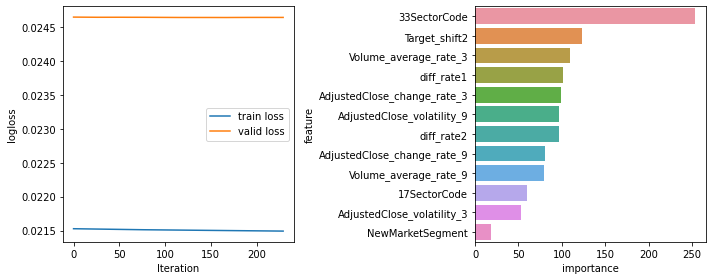

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2349
[LightGBM] [Info] Number of data points in the train set: 417012, number of used features: 12
[LightGBM] [Info] Start training from score 0.000231
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0218369	Valid's rmse: 0.0222489
[200]	Train's rmse: 0.0218222	Valid's rmse: 0.0222374
[300]	Train's rmse: 0.0218114	Valid's rmse: 0.0222283
[400]	Train's rmse: 0.0218025	Valid's rmse: 0.022224
[500]	Train's rmse: 0.0217946	Valid's rmse: 0.0222209
[600]	Train's rmse: 0.0217879	Valid's rmse: 0.0222185
[700]	Train's rmse: 0.0217809	Valid's rmse: 0.0222161
[800]	Train's rmse: 0.0217746	Valid's rmse: 0.0222147
[900]	Train's rmse: 0.0217684	Valid's rmse: 0.0222121
Early stopping, best iteration is:
[884]	Tr

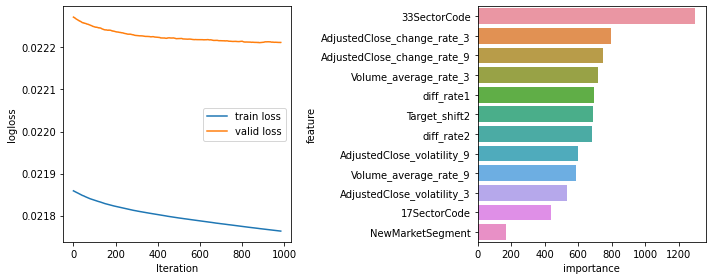

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2349
[LightGBM] [Info] Number of data points in the train set: 420982, number of used features: 12
[LightGBM] [Info] Start training from score 0.000290
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.021551	Valid's rmse: 0.0251076
[200]	Train's rmse: 0.0215301	Valid's rmse: 0.0250843
[300]	Train's rmse: 0.0215163	Valid's rmse: 0.0250724
[400]	Train's rmse: 0.0215054	Valid's rmse: 0.0250658
[500]	Train's rmse: 0.0214961	Valid's rmse: 0.0250569
[600]	Train's rmse: 0.0214881	Valid's rmse: 0.0250543
[700]	Train's rmse: 0.0214805	Valid's rmse: 0.0250527
[800]	Train's rmse: 0.0214735	Valid's rmse: 0.0250511
[900]	Train's rmse: 0.0214666	Valid's rmse: 0.0250496
[1000]	Train's rmse: 0.02146	Valid's rmse: 0.0250453
[1100]	Train's rmse: 0.0214541	Valid's rmse: 0.0250447

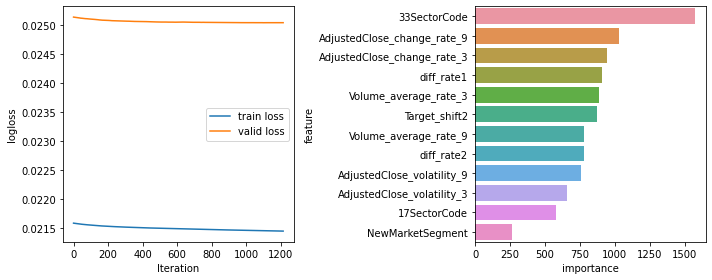

CV_SCORES: [0.31993831225587316, 0.3358022603088788, 0.18535847335683178]
CV_SCORE: 0.2803663486405279


In [17]:
# Since the data before 2020-12-23 does not have all 2000 securities codes,
# ,only the data after that will be used.
# (Start date of training data, end date of training data = start date of verification data
# , end date of verification data)
fold_params = [
    ('2020-12-23', '2021-11-01', '2021-12-01'),
    ('2021-01-23', '2021-12-01', '2022-01-01'),
    ('2021-02-23', '2022-01-01', '2022-02-01'),
]
models = trainer(feature_df, feat_cols, label_col, fold_params)

## Reasoning / evaluation
* Use the generated model to infer test data and calculate the score.

In [18]:
def predictor(feature_df, feat_cols, models, is_train=True):
    X = feature_df[feat_cols]
    
    # inference
    preds = list(map(lambda model: model.predict(X, num_iteration=model.best_iteration), models))
    
    # Score is calculated only during learning
    if is_train:
        scores = list(map(lambda pred: evaluator(feature_df, pred), preds))
        print("SCORES:", scores)

    # Bagging inference results
    pred = np.array(preds).mean(axis=0)

    # Score is calculated only during learning
    if is_train:
        score = evaluator(feature_df, pred)
        print("SCORE:", score)
    
    return pred

In [19]:
# Use test data that is not used for learning or verification
test_df = feature_df[('2022-02-01' <= feature_df['Date'])].copy()
pred = predictor(test_df, feat_cols, models)

SCORES: [0.01907126215704745, 0.030744911130916208, 0.0838496416440461]
SCORE: 0.05602107949179019


## Submission

* Register the inference result using the time series API.
* Since we have adopted a value that refers to past data such as moving averages as a feature quantity, it is necessary to implement a mechanism to store the data obtained from the time series API.
* Regarding this mechanism, I referred to "Start-to-finish demo based on s-meitoma + tweaks".
* https://www.kaggle.com/code/lowellniles/start-to-finish-demo-based-on-s-meitoma-tweaks
* The code below is an implementation that stores historical data in a data frame called past_df.

In [20]:
# Set up supplemental files as the initial state of historical data
past_df = supplemental_df.copy()

In [ ]:
# Daily reasoning / registration
for i, (prices, options, financials, trades, secondary_prices, sample_prediction) in enumerate(iter_test):
    current_date = prices["Date"].iloc[0]

    if i == 0:
        # To prevent leaks, delete future data from the data received from the time series API
        past_df = past_df[past_df["Date"] < current_date]

    
    #Delete old history to secure resources
    threshold = (pd.Timestamp(current_date) - pd.offsets.BDay(80)).strftime("%Y-%m-%d")
    past_df = past_df[past_df["Date"] >= threshold]
    
    #Integrate data received from time series API into historical data
    base_df = collector(prices, options, financials, trades, secondary_prices, stock_list)
    past_df = pd.concat([past_df, base_df]).reset_index(drop=True)

    # Feature engineering
    feature_df, feat_cols, label_col = preprocessor(past_df, False)

    # Extract only predictable records
    feature_df = feature_df[feature_df['Date'] == current_date]

    
    #Inference
    feature_df["pred"] = predictor(feature_df, feat_cols, models, False)

    
    # Derivate RANK from the inference result and reflect it in the submitted data
    feature_df = add_rank(feature_df)
    feature_map = feature_df.set_index('SecuritiesCode')['Rank'].to_dict()
    sample_prediction['Rank'] = sample_prediction['SecuritiesCode'].map(feature_map)

    
    #Register result
    env.predict(sample_prediction)

NameError: name 'iter_test' is not defined

In [ ]:
stock_list 
train_files 
supplemental_files

# End of notebook

## adjclose

In [ ]:
def adjust_price(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)

    price.set_index("Date", inplace=True)
    return price

## analysis

In [ ]:
df_price = pd.concat([df_price, df_price_supplemental])
# generate AdjustedClose
df_price = adjust_price(df_price)
price = df_price.loc[df_price["SecuritiesCode"] == 7203].copy()

In [ ]:
price = df_price.loc[df_price["SecuritiesCode"] == 7203].copy()

In [ ]:
price = price.filter(items=["SecuritiesCode", 'Open','High','Low','Volume','AdjustedClose','Target'])

In [ ]:
price

In [ ]:
periods = [10, 21, 63]
return_names = []
for period in periods:
    return_names.append(f"return_{period}")
    price.loc[:, f"return_{period}"] = price["AdjustedClose"].pct_change(period)

In [ ]:
price[return_names].plot(figsize=(20, 8))

In [ ]:
# Returns
def returns(df, n):
    df[f"returns_{n}"] = df["AdjustedClose"].pct_change(n)
    return df
price=returns(price, 10)
price=returns(price, 21)
price=returns(price, 63)

In [ ]:
price.iloc[:,-3:].plot(figsize=(20, 8))

In [ ]:

# Volatilities
def Volatilities(df, n):
    df[f"Volatilities_{n}"] = np.log(df["AdjustedClose"]).diff().rolling(n).std()
    return df
price=Volatilities(price, 10)
price=Volatilities(price, 21)
price=Volatilities(price, 63)

In [ ]:
price.iloc[0:25]

In [ ]:
np.log(price["AdjustedClose"]).diff().rolling(10).std()

In [ ]:
np.log(price["AdjustedClose"]).diff().std()

In [ ]:
np.log(price["AdjustedClose"]/price["AdjustedClose"].shift(1))